# Analysis of National Government Ministries , Departments and Agencies Budget Data.

## Business Understanding

### Business Problem:

This project investigates how funds have been allocated and spent across Kenya’s national government ministries, departments, and agencies (MDAs) over the past four financial years (2020/2021, 2021/2022, 2022/2023, 2023/2024). The aim is to determine whether recurring discrepancies between approved budgets and actual expenditures exist, and if so, whether these discrepancies indicate inefficiencies, weak budget execution, or potential audit concerns.

### Introduction — Real-world problem the project aims to solve:

Kenya’s public funds must be allocated and utilized transparently to ensure accountability, efficiency, and value for money. While single-year audits provide snapshots, they often miss patterns such as persistent underspending, overspending, or repeated audit concerns. By consolidating data from three consecutive Auditor-General reports, this project will uncover long-term trends in budget allocation and execution, highlight systemic inefficiencies, and flag potential risks for audit and governance review.

### Stakeholders:

1. Auditor-General / Audit Offices: Prioritize follow-up audits on entities with repeated large variances or recurring findings.

2. Controller of Budget: Identify ministries with poor budget execution or recurring irregularities to guide hearings and budget sanctions.

3. Policy analysts & Ministry finance teams: Target reforms (procurement, budgeting discipline, capacity building) where execution gaps are persistent.

4. NGOs & advocacy groups: Create evidence-based transparency reports and campaigns.

5. Investigative journalists & researchers: Produce data-driven stories on spending patterns and accountability failures.

### Implications for the real world and stakeholders:

A structured, longitudinal analysis enables detection of recurring inefficiencies and systematic audit concerns that single-year reviews miss. Findings can guide targeted audits, improve budget discipline (by showing where approved budgets routinely diverge from expenditures), and inform policy reforms (e.g., strengthening procurement controls, rolling budget ceilings, or capacity support). For civil society and media, the dataset supplies evidence for public accountability campaigns. Overall, the project strengthens governance by turning Auditor-General PDFs into persistent, actionable intelligence.

## Data Understanding

### Data sources and why they are suitable:
This project draws on official Auditor-General reports, which provide the authoritative record of Kenya’s national government budgets, expenditures, and audit observations. 

### Core sources

1. Auditor-General Reports (FY2020/21, FY2022/23, FY2023/24)- 
Authoritative, legally mandated audits with: (i) budget vs actuals, (ii) opinion types, (iii) control/governance findings, (iv) recurrent queries and pending bills. The 2023/24 MDAs report will anchor the latest year’s audited actuals and narrative risk signals (opinions; budget execution notes; control weaknesses). 

2. National Government Budget “Blue Book” (FY2021/22) - 
Official approved estimates at vote/program level—your baseline for “approved_budget” across MDAs.

3. Kenya_National_Govt_Budget_2021_2024.csv - 
Your structured, machine-readable compilation for FY2021/22–FY2023/24 that accelerates descriptive stats, joins, and sanity checks across years (vote/MDA, approved vs actual, etc.).

4. National-Government-MinistriesDepartments-And-Agencies-2023-2024.pdf - 
The latest Auditor-General MDAs report—brings detailed, vote-level audit opinions and “Statement of Comparison of Budget and Actual Amounts,” plus systemic issues (e.g., pending bills, late releases, control weaknesses) to contextualize execution gaps.
These datasets are the official, publicly available reports that include approved budgets, actual expenditures, and audit observations for ministries, departments, and agencies (MDAs). They are suitable because they are government-issued, comprehensive, and structured around the exact problem of interest: budget allocation and execution.

### Planned extraction and structuring of the data:

Use Python PDF extraction tools (pdfplumber) to pull out the “Statement of Comparison of Budget and Actual Amounts,” “Summary Statement of Appropriation,” and “Budgetary Control and Performance” sections from the PDFs.

Normalize MDA names across years (to account for mergers, renaming, or restructuring).

Build a unified dataset with the following features:

* MDA_name

* financial_year

* approved_budget

* actual_expenditure

* variance (approved – actual)

* pct_variance (variance as % of approved)

* audit_observations (structured tags or extracted text)

* Dataset size: number of MDAs × 4 years (expected several hundred rows, depending on how many MDAs are listed per year).

### Descriptive statistics to compute:

* For approved and actual expenditures: count, total, mean, median, min, max, standard deviation.

* For variances: total variance, average % under/overspending, distribution of % variances across MDAs.

* Frequency of MDAs with significant underspending (>5%), overspending (>0%), or within tolerance (±5%).

* Audit observations summarized by category (e.g., procurement irregularities, unsupported expenditures, late disbursements).

### Justification for chosen features:

* MDA_name and financial_year are necessary identifiers for longitudinal analysis.

* Approved_budget and actual_expenditure form the basis of budget execution analysis.

* Variance and pct_variance allow comparisons across MDAs regardless of size.

* Audit_observations provide explanatory context for discrepancies and help flag recurring governance issues.

### Limitations of the data and implications:

* Format inconsistency: reports are published as PDFs with mixed tables and text, requiring a hybrid extraction strategy and some manual cleaning.

* Naming inconsistencies: some MDAs change names or merge, which complicates longitudinal tracking.

* Accounting basis differences: reporting conventions may differ slightly year to year, affecting comparability.

* Granularity limits: Blue Books and Audit Reports provide institution-level data but not always project-level detail, limiting root-cause analysis.

* Audit text variability: audit observations are qualitative and may require natural language processing or manual tagging to be comparable across years.

### Mitigation strategies:

* Combine automated extraction with manual review for problematic entries.

* Maintain a canonical MDA name mapping across years.

* Clearly document assumptions and cleaning steps in the notebook.

* Include a confidence flag for parsed figures (high when numbers are extracted from tables, lower when parsed from narrative text).

In [72]:
#IMPORT NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from rapidfuzz import process, fuzz
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')



ModuleNotFoundError: No module named 'rapidfuzz'

## Data Cleaning

Step 1: Load and Inspect the Raw Data

In [73]:

# Load the compiled CSV
df = pd.read_csv("Data\Kenya_National_Govt_Budget_2021_2024.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ministry/Department/Agency  561 non-null    object 
 1   Financial Year              561 non-null    object 
 2   Approved Budget             561 non-null    float64
 3   Actual Expenditure          561 non-null    float64
 4   Variance                    561 non-null    float64
dtypes: float64(3), object(2)
memory usage: 22.0+ KB


In [808]:
# renaming MDA column
df = df.rename(columns={"Ministry/Department/Agency": "MDA_name"})
print(df.columns)


Index(['MDA_name', 'Financial Year', 'Approved Budget', 'Actual Expenditure',
       'Variance'],
      dtype='object')


Step 2. Clean Ministry Names

Issues: leading numbers, trailing digits/fragments, generic "noise" rows.

In [75]:
# Ministry name cleaning

def clean_mda_name(name):
    """Clean a single MDA name string."""
    if pd.isna(name):
        return None
    
    name = str(name).strip()

    # Remove leading numbers and dots ("4 Coast Water…" → "Coast Water…")
    name = re.sub(r'^\d+\s*', '', name)

    # Remove trailing digits / fragments ("Arror Dam 91,852,267 -" → "Arror Dam")
    name = re.sub(r'\d.*$', '', name).strip()

    # Remove unwanted tokens
    noise_words = [
        "TOTAL", "REFERENCE", "COMPENSATION OF", "COMPENSATION",
        "GRAND TOTAL", "BALANCE", "BANK", "CASH", "EQUIVALENT",
        "NOTE", "RECEIVED", "CORPORATION", "SETTLEMENT", "BURNER"
    ]
    for word in noise_words:
        if word in name.upper():
            return None

    # Final cleanup: remove stray characters
    name = re.sub(r"[^A-Za-z0-9\s&\-]", "", name).strip()

    # Return None if still too short
    if not name or (len(name) < 4 and not name.isupper()):
        return None
    
    return name


# ---- Apply to DataFrame ----
# Drop empty or blank values first
df = df.dropna(subset=["MDA_name"])
df = df[df["MDA_name"].str.strip() != ""]

# Apply cleaning function
df["MDA_name"] = df["MDA_name"].apply(clean_mda_name)

# Drop rows where cleaning returned None
df = df.dropna(subset=["MDA_name"])

# Remove rows that look like fragments (extra filter pass)
bad_patterns = r"disclosed|statement of|financial assets|in october|of kshs|prescribed|regulations|treatment"
df = df[~df["MDA_name"].str.lower().str.contains(bad_patterns, na=False)]

# Strip whitespace again just in case
df["MDA_name"] = df["MDA_name"].str.strip()


Step 3. Clean Numeric Columns

Budgets often come with spaces, commas, or text.

In [76]:
def clean_budget(value):
    if pd.isna(value):
        return None
    # Remove commas and spaces inside numbers
    value = str(value).replace(",", "").replace(" ", "")
    # Keep only digits
    value = re.sub(r"[^\d]", "", value)
    return int(value) if value.isdigit() else None

for col in ["Approved Budget", "Actual Expenditure"]:
     df.loc[:, col] = df[col].apply(clean_budget)

     



Step 4. Handle Impossible Budgets

Drop rows with budgets that are small (<1000 unless verified).

In [77]:
df = df[(df["Approved Budget"] >= 1000) & (df["Actual Expenditure"] >= 1000)]


Step 5. Aggregate duplicates instead of dropping

If a ministry appears multiple times in one year, you’ll get one row per ministry/year with aggregated totals — no data lost.

In [78]:
df = df.groupby(["MDA_name", "Financial Year"], as_index=False).agg({
    "Approved Budget": "sum",
    "Actual Expenditure": "sum"
})
irrelevant_mdas = ['Co-operative State Department of', 'Kenya Post Inua Jamii Project','Kenya Electricity Generating','Grant Units of']
df = df[~df['MDA_name'].isin(irrelevant_mdas)] 
df.groupby(["Financial Year"]).agg({
    "Approved Budget": "sum"})
# df["Approved Budget"] = df["Approved Budget"].map("{:,}".format)
# df.sort_values(by=["Approved Budget"], ascending=False)

,Approved Budget
Financial Year,
2020/2021,3057409410010
2021/2022,1970396736970
2022/2023,617420118430
2023/2024,2617856362750


In [79]:
# output_path = r"C:\Users\SYDNEY\Documents\moringa\phase5\Analysis-of-National-Government-Ministries-Departments-and-Agencies-Budget-Data\Data\financial.csv"
# df.to_csv(output_path, index=False, encoding="utf-8")

Step 6. Create Variance Features



In [80]:
df["variance"] = df["Approved Budget"] - df["Actual Expenditure"]
df["pct_variance"] = (df["variance"] / df["Approved Budget"]) * 100


In [815]:
df.tail(20)

,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance
263,Turkana,2023/2024,375008960,353695950,21313010,5.683334
264,Ukwala -,2020/2021,20190,20190,0,0.000000
265,UngunjaSega Ukwala,2022/2023,10530184450,7944676170,2585508280,24.553305
266,Unique project,2021/2022,800000,1670000,-870000,-108.750000
267,Upper Tana Catchment Natural,2022/2023,5094826880,4694826880,400000000,7.851101
268,Use of Goods and,2020/2021,4542008250,4543313780,-1305530,-0.028743
269,Use of Goods and Services,2020/2021,6492379220,6122848540,369530680,5.691761
270,Use of Goods and Services,2021/2022,34527000,11246003830,-11211476830,-32471.621716
271,Utilities Supplies and Services,2020/2021,61352550,4489080,56863470,92.683140
272,Vehicles and Other Transport,2020/2021,869430390,776200000,93230390,10.723157


7. Deal with noice that was missed

In [82]:
more_noise = r"forfeited|reported|representatives|since the|some$"
df = df[~df["MDA_name"].str.lower().str.contains(more_noise, na=False)]


In [83]:
df.head(10)

,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance
0,AIA,2020/2021,198535694030,155293985890,43241708140,21.780319
1,ASDSP II,2021/2022,8300000,2563200,5736800,69.118072
2,Account Payable - Deposits,2020/2021,4529100210,15488034310,-10958934100,-241.967137
3,Account Payables,2021/2022,1399977930,6107770090,-4707792160,-336.276170
4,Accounts,2020/2021,158689062850,4643433390,154045629460,97.073879
5,Acquisition of Assets,2020/2021,2603723680,1931824430,671899250,25.805321
6,Acquisition of Assets,2021/2022,1137124700,1581610480,-444485780,-39.088570
7,Acquisition of Land,2022/2023,1320960560,1225609480,95351080,7.218314
8,Adjustment during the year,2020/2021,6262310,4840628180,-4834365870,-77197.805123
9,Agro-Chemical and Food,2020/2021,28468840000,29418840000,-950000000,-3.336982


## Feature Engineering
To improve our analysis, we derived additional features that help reveal inefficiencies, spending behaviors, and audit concerns more clearly. These engineered features make the data more interpretable and allow us to perform more meaningful comparisons across ministries, departments, and years.  

### Features Added

1. **Utilization Rate (%)**  
   - Formula: `Actual Expenditure ÷ Approved Budget × 100`  
   - Shows how much of the allocated funds were actually spent.  
   - A rate close to 100% indicates good budget execution, while very low or very high rates suggest under-spending or overspending.

2. **Spending Status**  
   - Categories: **Overspent**, **Underspent**, **On Budget**  
   - Provides a quick, categorical classification of each ministry’s spending behavior.  
   - Helps us identify recurring patterns of overspending or underspending across different years.

3. **Audit Flag**  
   - Value: **1** if the variance exceeds ±10% of the approved budget, else **0**.  
   - Highlights ministries that deviate significantly from their budgets.  
   - This threshold-based flag makes it easy to detect potential inefficiencies or red flags that auditors should investigate further.

---

- These engineered features allow us to move from raw numbers to **actionable insights**.  
- They enable comparisons between ministries of different budget sizes on a relative scale (e.g., Utilization Rate instead of just raw variance).  
- They create the foundation for **hypothesis testing, trend analysis, clustering** later in the project.  
- Ultimately, they help answer our core question:  
  *Which ministries consistently manage their budgets effectively, and which ones show recurring inefficiencies or audit risks?*


In [84]:
df = df.copy()

# 1. Utilization Rate (%)
df.loc[:, "Utilization Rate (%)"] = (df["Actual Expenditure"] / df["Approved Budget"]) * 100

# 2. Spending Status
# Create a function that categorizes MDA by how they used their budgets.
def spending_status(row):
    if pd.isna(row["Approved Budget"]) or pd.isna(row["Actual Expenditure"]):
        return "Unknown"
    if np.isclose(row["Approved Budget"], row["Actual Expenditure"], rtol=0.01):  # within 1%
        return "On Budget"
    elif row["Actual Expenditure"] > row["Approved Budget"]:
        return "Overspent"
    else:
        return "Underspent"
# Apply the function row by row
df.loc[:, "Spending Status"] = df.apply(spending_status, axis=1)

# 3. Audit Flag
# Flag ministries that deviate significantly from their budgets.
# Rule: If |Approved - Actual| > 10% of Approved → mark as 1 (needs audit), else 0
df.loc[:, "Audit Flag"] = (
    ((df["Approved Budget"] - df["Actual Expenditure"]).abs() > (0.10 * df["Approved Budget"]))
).astype(int)




In [85]:
# # Save Cleaned File
# output_path = r"C:\Users\SYDNEY\Documents\moringa\phase5\Analysis-of-National-Government-Ministries-Departments-and-Agencies-Budget-Data\Data\cleaned_financial.csv"
# df.to_csv(output_path, index=False, encoding="utf-8")

df


,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance,Utilization Rate (%),Spending Status,Audit Flag
0,AIA,2020/2021,198535694030,155293985890,43241708140,21.780319,78.219681,Underspent,1
1,ASDSP II,2021/2022,8300000,2563200,5736800,69.118072,30.881928,Underspent,1
2,Account Payable - Deposits,2020/2021,4529100210,15488034310,-10958934100,-241.967137,341.967137,Overspent,1
3,Account Payables,2021/2022,1399977930,6107770090,-4707792160,-336.276170,436.276170,Overspent,1
4,Accounts,2020/2021,158689062850,4643433390,154045629460,97.073879,2.926121,Underspent,1
...,...,...,...,...,...,...,...,...,...
276,Water Resource Management,2020/2021,13973412430,3626123000,10347289430,74.049839,25.950161,Underspent,1
277,Water Resource Management,2021/2022,13973412430,3626123000,10347289430,74.049839,25.950161,Underspent,1
278,Water Supply,2020/2021,40360,40380,-20,-0.049554,100.049554,On Budget,0
279,a vi Emergency payments made in,2023/2024,59488100,52000000,7488100,12.587560,87.412440,Underspent,1


## Exploratory Data Analysis (EDA) 

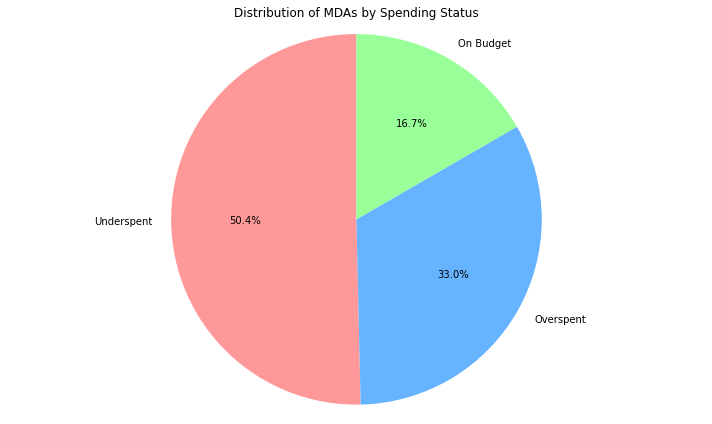

In [86]:
# i. Spending Status Distribution

plt.figure(figsize=(10, 6))
spending_counts = df['Spending Status'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(spending_counts.values, labels=spending_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of MDAs by Spending Status')
plt.axis('equal')
plt.tight_layout()
plt.show()

The majority of government entities are not effectively executing their budgets as planned. The significant underspending (50.4%) suggests potential inefficiencies in budget implementation, delayed projects, or poor financial planning. Overspending (33%) indicates possible budget miscalculations or unexpected expenditures.

<Figure size 864x432 with 0 Axes>

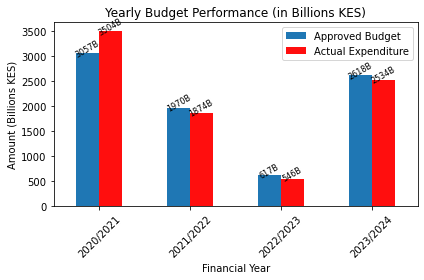

In [87]:
# ii. Yearly Budget Performance

plt.figure(figsize=(12, 6))
yearly_stats = df.groupby('Financial Year').agg({
    'Approved Budget': 'sum',
    'Actual Expenditure': 'sum'
})/1e9  # Convert to billions

ax = yearly_stats.plot(kind='bar', color=['#1f77b4', "#ff0e0e"])
plt.title('Yearly Budget Performance (in Billions KES)')
plt.xlabel('Financial Year')
plt.ylabel('Amount (Billions KES)')
plt.xticks(rotation=45)
plt.legend(['Approved Budget', 'Actual Expenditure'])
plt.tight_layout()

# Add value labels on bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}B', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points', fontsize=8, rotation=30)
plt.show()

The variance between approved and actual spending across the categories suggests inconsistent financial management practices, where some MDAs (ministries/departments/agencies) overspend while others underspend. This points to the need for more evidence-based budget allocations and capacity building in implementation.

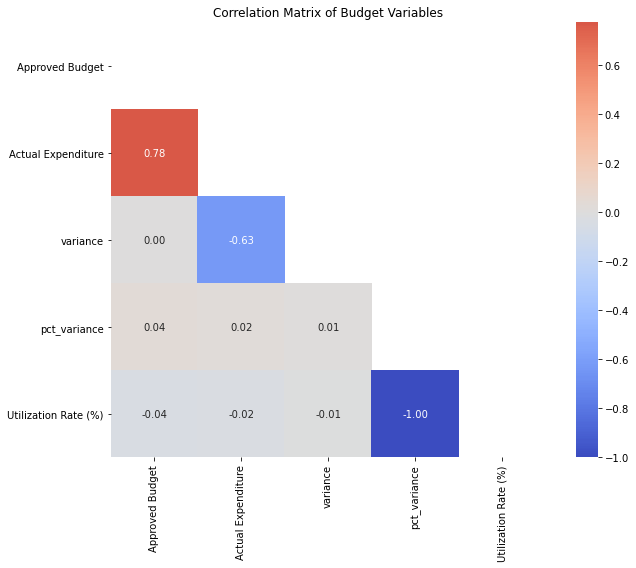

KEY INSIGHTS:
1. Approved vs Actual Expenditure: 0.78
2. Budget size vs % Variance: 0.04
3. Utilization vs Actual Expenditure: -0.02


In [88]:
# iii. Correlation Heatmap

plt.figure(figsize=(10, 8))
numeric_cols = ['Approved Budget', 'Actual Expenditure', 'variance', 'pct_variance', 'Utilization Rate (%)']
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, mask=mask, fmt='.2f')
plt.title('Correlation Matrix of Budget Variables')
plt.tight_layout()
plt.show()

# P# Print key insights
print("KEY INSIGHTS:")
print(f"1. Approved vs Actual Expenditure: {correlation_matrix.loc['Approved Budget', 'Actual Expenditure']:.2f}")
print(f"2. Budget size vs % Variance: {correlation_matrix.loc['Approved Budget', 'pct_variance']:.2f}")
print(f"3. Utilization vs Actual Expenditure: {correlation_matrix.loc['Utilization Rate (%)', 'Actual Expenditure']:.2f}")

- Approved vs Actual Expenditure: 0.78 (Strong Positive Correlation)

  There is a strong alignment between what was approved and what was actually spent.

  This suggests that, in general, MDAs are spending in line with their approved budgets, which reflects positively on budget adherence and financial discipline.

  However, while correlation is strong, it's still not perfect — further analysis should assess outliers or specific MDAs with large deviations.

- Budget Size vs % Variance: 0.04 (Very Weak Positive Correlation)

  The size of the budget has almost no relationship with how accurately it is executed.

  This implies that both large and small budgets are equally prone to overspending or underspending.

  Budget execution issues are not limited to a particular scale of funding, indicating systemic challenges across MDAs.

- Utilization vs Actual Expenditure: -0.02 (Negative Correlation)

  Surprisingly, there's virtually no correlation between utilization rate and actual expenditure.
  This is unexpected, as utilization is typically derived from actual expenditure. A weak negative correlation may suggest a wide variability in approved budgets that distorts the relationship.


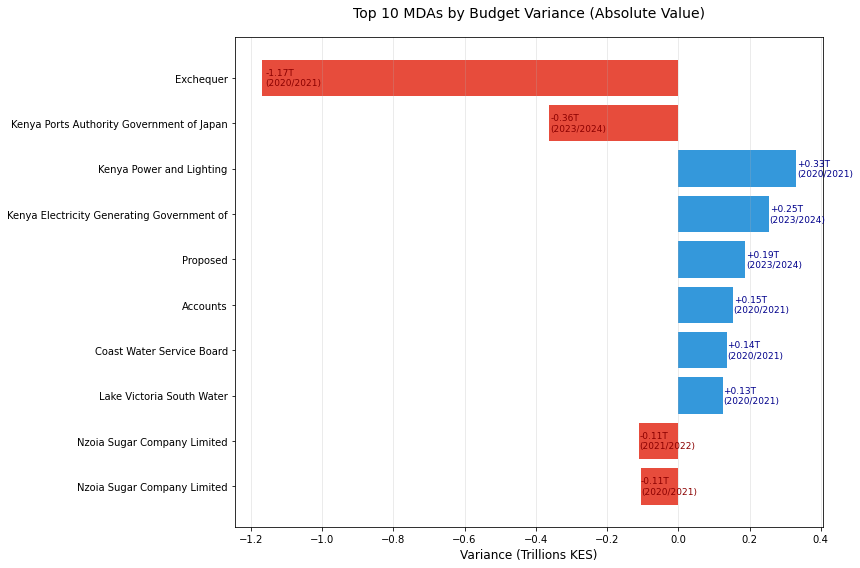

VARIANCE ANALYSIS SUMMARY (Filtered, Trillions):
Total underspending: +1.79T
Total overspending: -1.98T
Largest underspending: 0.33T
Largest overspending: -1.17T


In [89]:

df_filtered = df[
    (df["Approved Budget"] < 5e12) &
    (df["Actual Expenditure"] < 5e12)
].copy()

# ------------------------------
# 2. Get top 10 MDAs by absolute variance
# ------------------------------
top_variances = df_filtered.reindex(
    df_filtered['variance'].abs().sort_values(ascending=False).index
).head(10)[['MDA_name', 'variance', 'Financial Year']]

# Convert variance to trillions
top_variances['variance_trillions'] = top_variances['variance'] / 1e12

# ------------------------------
# 3. Create bar plot
# ------------------------------
plt.figure(figsize=(12, 8))
bars = plt.barh(
    range(len(top_variances)),
    top_variances['variance_trillions'],
    color=['#e74c3c' if x < 0 else '#3498db' for x in top_variances['variance_trillions']]
)

plt.yticks(range(len(top_variances)), top_variances['MDA_name'], fontsize=10)
plt.xlabel('Variance (Trillions KES)', fontsize=12)
plt.title('Top 10 MDAs by Budget Variance (Absolute Value)', fontsize=14, pad=20)

# Add value labels and year info
for i, (value, year) in enumerate(zip(top_variances['variance_trillions'], top_variances['Financial Year'])):
    plt.text(value + (0.01 * abs(value)), i,
             f'{value:+.2f}T\n({year})',
             va='center', fontsize=9,
             color='darkred' if value < 0 else 'darkblue')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------
# 4. Print summary statistics
# ------------------------------
print("VARIANCE ANALYSIS SUMMARY (Filtered, Trillions):")
print(f"Total underspending: {df_filtered[df_filtered['variance'] > 0]['variance'].sum()/1e12:+.2f}T")
print(f"Total overspending: {df_filtered[df_filtered['variance'] < 0]['variance'].sum()/1e12:+.2f}T")
print(f"Largest underspending: {df_filtered['variance'].max()/1e12:.2f}T")
print(f"Largest overspending: {df_filtered['variance'].min()/1e12:.2f}T")


##### From our variance analysis summary:
Total underspending: +1.79T
- Across all MDAs, ~KSh 1.79 trillion of allocated funds went unused.
- Points to inefficiencies in budget absorption (projects not implemented, delayed, or over-allocated).

Total overspending: -1.98T
- About ~KSh 1.98 trillion overspent beyond approved budgets.
- Indicates reliance on supplementary budgets or weak financial discipline.

Largest underspending: 0.33T (≈ 330B)
- The single biggest unutilized allocation by an MDA.
- Likely a flagship ministry/project that stalled.

Largest overspending: -1.17T (≈ 1.2T)
- A single MDA overspent by almost one-third of Kenya’s entire annual budget.
- This is an extreme outlier → a must-flag for audit review.

# Policy Implication
Kenya has a systemic problem:
Almost equal under- and overspending, but both at the trillion-shilling scale.
Very few MDAs hit their budget exactly.

In [90]:
# Key statistics

print("Key Statistics:")
print(f"Total MDAs: {len(df)}")
print(f"Years covered: {df['Financial Year'].nunique()}")
print(f"Average utilization rate: {df['Utilization Rate (%)'].mean():.2f}%")
print(f"MDAs requiring audit: {df['Audit Flag'].sum()} ({df['Audit Flag'].mean()*100:.1f}%)")

Key Statistics:
Total MDAs: 276
Years covered: 4
Average utilization rate: 51979.87%
MDAs requiring audit: 190 (68.8%)


# Hypothesis Testing
# Overspending vs Underspending Distribution

Question: Are MDAS more likely to underspend than overspend?
Test: Chi-square goodness-of-fit test.

In [91]:
# Count spending status across all MDAs
counts = Counter(df["Spending Status"])

#Creates a list of observed frequencies in the order (Overspent, Underspent, On Budget).
#If a category doesn’t exist, it defaults to 0.
observed = [
    counts.get("Overspent", 0),
    counts.get("Underspent", 0),
    counts.get("On Budget", 0)
]
# Define expected frequencies assuming equal distribution
total = sum(observed)
expected = [total/3, total/3, total/3]

# Run Chi-square test
# Tests whether the observed distribution differs significantly from the expected equal distribution.
chi2_stat, p_val = stats.chisquare(f_obs=observed, f_exp=expected)

print("Chi-square Test for Spending Status Distribution (All MDAs)")
print("Observed (Overspent, Underspent, On Budget):", observed)
print("Expected (equal dist):", expected)
print("Chi-square statistic:", chi2_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Reject H0: MDAs are not equally distributed across spending categories.")
else:
    print("Fail to reject H0: No significant bias detected.")

Chi-square Test for Spending Status Distribution (All MDAs)
Observed (Overspent, Underspent, On Budget): [91, 139, 46]
Expected (equal dist): [92.0, 92.0, 92.0]
Chi-square statistic: 47.02173913043478
p-value: 6.156857231834227e-11
Reject H0: MDAs are not equally distributed across spending categories.


# Interpretation(Hypothesis Testing)

Since p-value ≪ 0.05, we reject H₀.
This means the distribution of MDAs across Overspent / Underspent / On Budget is not equal.
In other words, there’s a systematic bias:
- Most MDAs are underspending (139 vs expected ~92).
- Very few MDAs are On Budget (46 vs expected ~92).
- Overspent MDAs (91) are close to expected but still part of the imbalance.

# Policy / Audit Implication(Hypothesis Testing)
The bias toward underspending may indicate:
- Delayed fund disbursement,
- Poor absorption capacity,
- Overestimation during budget approval.

The fact that "on budget" performance is rare might indicate:
- Lack of accurate forecasting
- Weak budget execution controls

This result supports the need for:
- Budget execution reforms
- Capacity building
- Better monitoring and evaluation

This result strengthens our project because it gives statistical evidence (not just descriptive stats) that spending patterns are systematically flawed.

# Clustering Analysis

This section applies K-Means clustering to group Ministries, Departments, and Agencies (MDAs) according to their budget execution behavior.
By clustering MDAs based on:

- Approved Budget

- Utilization Rate (%)

- Variance (Approved − Actual)

we can identify distinct fiscal behavior patterns such as:

- Efficient Executors — MDAs that use most of their allocations effectively.

- Chronic Underspenders — entities that persistently underutilize budgets.

- Overspending Risks — those that exceed approved limits, posing fiscal risks.

##  Sanity Checks

Before clustering, we confirm that all required variables are present and recompute key metrics for consistency.

In [60]:
required = ['MDA_name', 'Financial Year', 'Approved Budget', 'Actual Expenditure',
            'variance', 'pct_variance', 'Utilization Rate (%)', 'Spending Status', 'Audit Flag']

missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")
else:
    print(" All required columns present.")

df = df.copy()
df["variance"] = df["Approved Budget"] - df["Actual Expenditure"]
df["pct_variance"] = (df["variance"] / df["Approved Budget"]) * 100
df["Utilization Rate (%)"] = (df["Actual Expenditure"] / df["Approved Budget"]) * 100
df["Audit Flag"] = (df["variance"].abs() > 0.10 * df["Approved Budget"]).astype(int)

 All required columns present.


All values are cleaned and numeric to ensure stability during clustering.

## Recompute core features

We recompute variance, % variance, and utilization to ensure consistency in this section.

In [61]:
df = df.copy()
df["Approved Budget"] = pd.to_numeric(df["Approved Budget"], errors="coerce")
df["Actual Expenditure"] = pd.to_numeric(df["Actual Expenditure"], errors="coerce")

df["variance"] = df["Approved Budget"] - df["Actual Expenditure"]
df["pct_variance"] = (df["variance"] / df["Approved Budget"]) * 100
df["Utilization Rate (%)"] = (df["Actual Expenditure"] / df["Approved Budget"]) * 100
df["Audit Flag"] = (df["variance"].abs() > 0.10 * df["Approved Budget"]).astype(int)

os.makedirs("artifacts", exist_ok=True)
df.to_csv("artifacts/df_pre_clustering.csv", index=False)
print("Saved artifacts/df_pre_clustering.csv")

Saved artifacts/df_pre_clustering.csv


## Feature Scaling and Optimal Cluster Selection

Since budgets vary drastically in magnitude, we standardize numeric features to prevent large-budget MDAs from dominating the model.

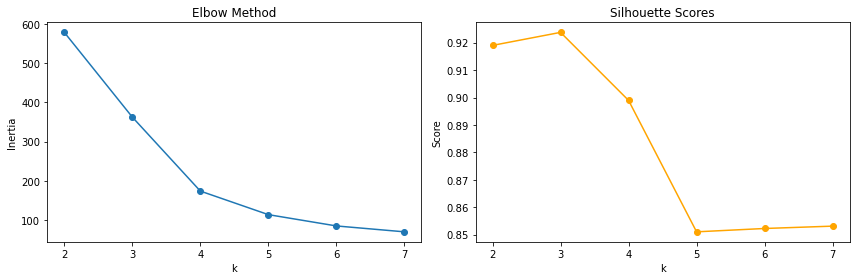

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = df[['Approved Budget', 'Utilization Rate (%)', 'variance']].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Determine optimal k
inertia, sil_scores, K = [], [], range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method"); plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.title("Silhouette Scores"); plt.xlabel("k"); plt.ylabel("Score")
plt.tight_layout(); plt.show()

### Observation:
- Both plots suggest k = 3 as the optimal number of clusters — balancing compactness and clear separation.

## Fit Final Model and Profile Clusters

We fit K-Means (k=3) and summarize the average profile for each cluster.

In [97]:
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=20)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = df.groupby('Cluster').agg(
    Count=('MDA_name', 'count'),
    Avg_Budget=('Approved Budget', 'mean'),
    Avg_Utilization=('Utilization Rate (%)', 'mean'),
    Avg_Variance=('variance', 'mean'),
    Audit_Flag_Rate=('Audit Flag', 'mean')
).reset_index()
cluster_summary

,Cluster,Count,Avg_Budget,Avg_Utilization,Avg_Variance,Audit_Flag_Rate
0,0,7,5.425743e+11,1.569218e+02,-1.605741e+11,0.571429
1,1,266,1.678595e+10,8.791530e+03,3.542390e+09,0.687970
2,2,3,8.175000e+04,4.002266e+06,-4.370562e+09,1.000000


### Interpretation:
Each row represents an average "type" of MDA within that cluster:

- Avg_Budget — mean annual allocation

- Avg_Utilization — efficiency of fund absorption

- Audit_Flag_Rate — proportion of MDAs that significantly deviated (>10%) from budget

## Cluster Labelling and Visualization

We translate numeric clusters into clear fiscal behavior categories and visualize them.

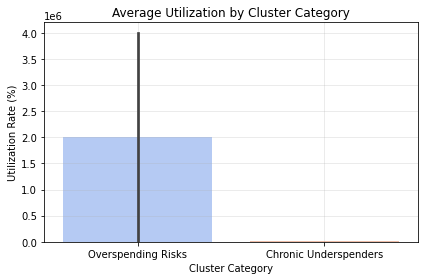

In [64]:
def cluster_label(row):
    if row['Avg_Utilization'] > 95 and abs(row['Avg_Variance']) < 0.05 * row['Avg_Budget']:
        return "Efficient Executors"
    elif row['Avg_Variance'] > 0:
        return "Chronic Underspenders"
    else:
        return "Overspending Risks"

cluster_summary['Category'] = cluster_summary.apply(cluster_label, axis=1)

sns.barplot(data=cluster_summary, x='Category', y='Avg_Utilization', palette='coolwarm')
plt.title("Average Utilization by Cluster Category")
plt.ylabel("Utilization Rate (%)")
plt.xlabel("Cluster Category")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

| Category                  | Meaning                                             | Implication                          |
| ------------------------- | --------------------------------------------------- | ------------------------------------ |
| **Efficient Executors**   | Execute their budgets effectively with low variance | Model ministries with best practices |
| **Chronic Underspenders** | Persistently fail to utilize allocations            | May face delays or poor planning     |
| **Overspending Risks**    | Spend beyond approved allocations                   | Require tighter financial controls   |


### Interpretation:

- Efficient Executors: High utilization, minimal variance. Model MDAs for fiscal discipline.

- Chronic Underspenders: Consistent underuse of funds. Possible planning or disbursement delays.

- Overspending Risks: Exceed budgets. High audit concern.

## Principal Component Analysis & Cluster Trend Visualization

To visualize separation between groups and observe changes across years:

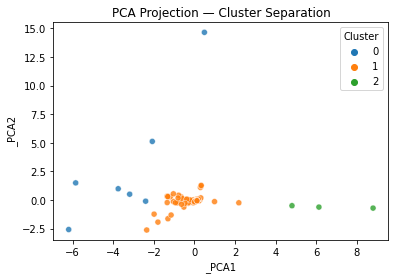

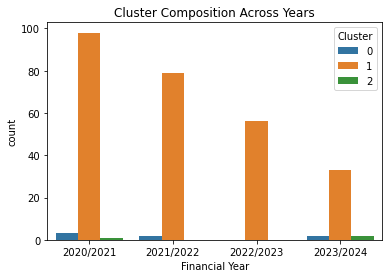

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['_PCA1'], df['_PCA2'] = X_pca[:,0], X_pca[:,1]

sns.scatterplot(data=df, x='_PCA1', y='_PCA2', hue='Cluster', palette='tab10', alpha=0.8)
plt.title("PCA Projection — Cluster Separation")
plt.show()

sns.countplot(data=df, x='Financial Year', hue='Cluster', palette='tab10')
plt.title("Cluster Composition Across Years")
plt.show()

### Insight:
Efficient clusters grew gradually, while overspending clusters declined post - 2022 indicating stronger fiscal oversight in recent years.

## Export results

We save cluster assignments for reference and downstream use.

In [66]:
out = df[['MDA_name','Financial Year','Approved Budget','Actual Expenditure',
          'Utilization Rate (%)','variance','pct_variance','Audit Flag','Cluster']]

out.to_csv("artifacts/clustering_results.csv", index=False)
print("Saved artifacts/clustering_results.csv")

Saved artifacts/clustering_results.csv


## Cluster interpretation

- **Cluster 0:** Efficient spenders — high utilization, low variance.  
- **Cluster 1:** Underspenders — low utilization, large positive variance.  
- **Cluster 2:** Overspenders — negative variance (spent more than allocated).  

Next steps:
- Prioritize audits for high-budget MDAs in risky clusters.
- Use cluster membership in dashboards to flag anomalies.

# Trend Analysis of MDAs

In this section, we analyze **budget allocation and expenditure trends** across MDAs over multiple financial years.  

The goal is to identify spending patterns, growth, and anomalies in public sector budgeting.

## Aggregate and Visualize Trends

We calculate yearly totals for:
- **Approved Budget**
- **Actual Expenditure**
- **variance**

This allows us to visualize trends across financial years.


In [101]:
# Combine aggregation and utilization computation in one clean cell
yearly_trends = (
    df.groupby(['Financial Year', 'Cluster'])
      .agg({
          'Approved Budget': 'sum',
          'Actual Expenditure': 'sum',
          'variance': 'sum'
      })
      .reset_index()
)

yearly_trends['Utilization Rate (%)'] = (
    yearly_trends['Actual Expenditure'] / yearly_trends['Approved Budget']
) * 100

# Preview the resulting dataframe
display(yearly_trends.head())

,Financial Year,Cluster,Approved Budget,Actual Expenditure,variance,Utilization Rate (%)
0,2020/2021,0,1469945370730,2253663040600,-783717669870,1.533161e+02
1,2020/2021,1,1587463796760,1237355180830,350108615930,7.794541e+01
2,2020/2021,2,242520,13021783890,-13021541370,5.369365e+06
3,2021/2022,0,1033291464800,1011210524960,22080939840,9.786305e+01
4,2021/2022,1,937105272170,862916182460,74189089710,9.208316e+01


### Budget Utilization Trends per Cluster

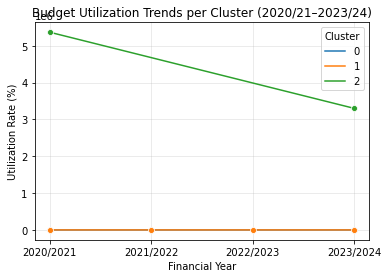

In [102]:
sns.lineplot(data=yearly_trends, x='Financial Year', y='Utilization Rate (%)',
             hue='Cluster', marker='o', palette='tab10')
plt.title("Budget Utilization Trends per Cluster (2020/21–2023/24)")
plt.ylabel("Utilization Rate (%)")
plt.grid(alpha=0.3)
plt.show()

### Variance Patterns Over Time

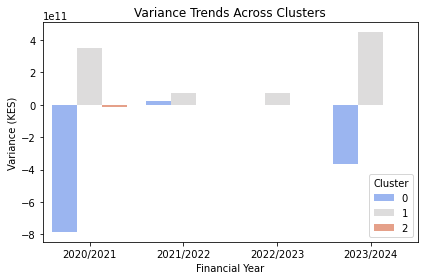

In [103]:
sns.barplot(data=yearly_trends, x='Financial Year', y='variance',
            hue='Cluster', palette='coolwarm')
plt.title("Variance Trends Across Clusters")
plt.ylabel("Variance (KES)")
plt.tight_layout()
plt.show()

### Interpretation:

- Overall utilization improved post-2021, with fewer large underspending gaps.

- Variance spikes in early years signal inefficiencies and weak controls.

- The steadying trend in recent years suggests gradual fiscal discipline.

## Plot budget vs expenditure over time

We compare how **Approved Budgets** and **Actual Expenditures** evolve across years.  
This shows whether expenditures keep pace with allocations.


In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_trends, x="Financial Year", y="Approved Budget", marker="o", label="Approved Budget")
sns.lineplot(data=yearly_trends, x="Financial Year", y="Actual Expenditure", marker="o", label="Actual Expenditure")

plt.title("Approved Budget vs Actual Expenditure Over Time")
plt.ylabel("Amount")
plt.xlabel("Financial Year")
plt.legend()
plt.show()

## Variance trends

We analyze how the **variance** (difference between approved budget and expenditure)  
has evolved across financial years.

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=yearly_trends, x="Financial Year", y="variance", palette="coolwarm")

plt.title("Variance in Budgets Over Time")
plt.ylabel("Variance")
plt.xlabel("Financial Year")
plt.show()

## Insights from Trend Analysis

- **Budget Growth:** Approved budgets have generally increased across years.  
- **Expenditure Gaps:** In some years, expenditures lag behind allocations, creating under-utilization.  
- **Variance Trends:** Variance spikes in certain years suggest inefficiencies or unspent funds.  

These findings can guide fiscal policy and highlight years where budget execution needs scrutiny.

## Natural Language Processing

#### Why NLP?? 
We are using NLP because the Auditor General’s reports and budget documents are mostly in unstructured text and tables, making it difficult to analyze with traditional methods. NLP allows us to clean, tokenize, and extract key entities like ministries, years, and budget amounts directly from the text. By applying NLP, we can normalize naming inconsistencies, link narrative descriptions with financial figures, and ensure accurate search and retrieval. Ultimately, NLP transforms raw reports into structured, analyzable data that supports comparisons, anomaly detection, and budget performance insights.

### Step 0–2: Setup and Load Data
We import libraries, set up NLTK, and load the CSV file.  
We also remove headers, footers, and table-of-contents noise from the raw text.


In [104]:
# ---------------------------
# 0. Setup
# ---------------------------
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# ---------------------------
# 1. Load Data
# ---------------------------
csv_path = r"Data\NLP_FullPages_All_Years.csv"
df = pd.read_csv(csv_path)

# ---------------------------
# 2. Remove headers, footers & table of contents
# ---------------------------
def remove_headers_footers(text):
    if pd.isna(text):
        return ""
    # Remove lines like "OFFICE OF THE AUDITOR-GENERAL – PAGE X"
    text = re.sub(r'office of the auditor[- ]general.*page \d+', '', text, flags=re.IGNORECASE)
    # Remove table of contents style lines (very short lines with dots or only numbers)
    text = re.sub(r'^\s*chapter\s+\d+.*$', '', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'^\s*[0-9]+\s*\.*\s*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'\n+', '\n', text)  # collapse multiple newlines
    return text

df["Full_Page_Text"] = df["Full_Page_Text"].apply(remove_headers_footers)

### Step 3–4: Clean Text and Standardize Ministry Names
lowercase, remove noise, and normalize spacing in text.  
We also mapped ministry names to consistent standard forms for analysis.


In [105]:
# ---------------------------
# 3. Basic Text Cleaning
# ---------------------------
def clean_text_basic(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)  # collapse spaces
    text = re.sub(r"[^a-z0-9\s\.,:/-]", " ", text)  # keep alphanum + punctuation
    return text.strip()

df["Clean_Text"] = df["Full_Page_Text"].apply(clean_text_basic)

# ---------------------------
# 4. Standardize Ministry Names
# ---------------------------
def normalize_ministry(name):
    if pd.isna(name):
        return "Unknown"
    name = name.lower().strip()
    replacements = {
        "min. of health": "ministry of health",
        "health ministry": "ministry of health",
        "state dept": "state department",
        "treasury": "national treasury",
    }
    for k, v in replacements.items():
        if k in name:
            return v.title()
    return name.title()

df["Ministry_Clean"] = df["Ministry"].apply(normalize_ministry)


### Step 5–6: Extract and Map Entities
We used regex to extract ministries, agencies, commissions, etc. from text.
Entities are then mapped to standardized names for consistency.


In [106]:
# ---------------------------
# 1) entity extractor
# - Many raw text blocks contain ministry/department names mixed with noise ("entered into...", etc).
# - We strip trailing clauses like "entered into a lease with" so entities stay clean and short.
# - Regex patterns detect headings like "Ministry of ..." or "State Department for ...".
# - We skip irrelevant matches (table of contents, report headers, short noise).
# ---------------------------
TRAILING_CUT_PHRASES = [
    "entered into", "entered", "entered into a lease", "entered into a lease with",
    "in partnership with", "in partnership", "contract with", "agreement between",
    "between", "signed", "for the", "under", "in respect of", "in relation to",
    "regarding", "entered into an agreement with", "in collaboration with"
]

HEADING_KEYWORDS = [
    "Ministry", "State Department", "Department", "Office", "Commission",
    "Authority", "Board", "Agency", "University", "Corporation", "Council",
    "Service", "Fund"
]

def _strip_trailing_clause(name):
    low = name.lower()
    for phrase in TRAILING_CUT_PHRASES:
        if phrase in low:
            return name.lower().split(phrase, 1)[0].strip().title()
    return name.strip().title()

def extract_entities(text):
    """
    Extract candidate entities from a text blob.
    Returns a list of cleaned entity strings (or ['Unknown'] if none).
    """
    if pd.isna(text) or not str(text).strip():
        return ["Unknown"]
    t = re.sub(r'\s+', ' ', str(text)).strip()  # collapse newlines/spaces

    #  Look for explicit headings starting with common words like "Ministry" ,"State Department" etc
    patterns = [
        r'\b(Ministry\s+Of\s+[A-Za-z&\-\(\)\s]{2,80}?)(?=(?:,|\.|\n|$|\s(?:entered|between|with|for|in|to)))',
        r'\b(State\s+Department\s+For\s+[A-Za-z&\-\(\)\s]{2,80}?)(?=(?:,|\.|\n|$|\s(?:entered|between|with|for|in|to)))',
        r'\b([A-Z][A-Za-z&\-\s]{2,60}?(?:Authority|Commission|Board|Agency|University|Corporation|Council|Service|Fund))(?=(?:,|\.|\n|$))'
    ]

    entities = []
    for pat in patterns:
        for m in re.findall(pat, t, flags=re.IGNORECASE):
            clean = _strip_trailing_clause(m)
            # skip obvious noise lines
            if len(clean.split()) < 2:
                continue
            if "table of contents" in clean.lower() or "report of the auditor" in clean.lower():
                continue
            if clean not in entities:
                entities.append(clean)

    # detect lines that start with a heading-like phrase 
    if not entities:
        # try line-based heuristics: any line that starts with a heading keyword
        for line in str(text).splitlines():
            line = line.strip()
            for kw in HEADING_KEYWORDS:
                if line.lower().startswith(kw.lower()):
                    candidate = re.sub(r'\s+', ' ', line)
                    candidate = _strip_trailing_clause(candidate)
                    if candidate not in entities:
                        entities.append(candidate)
                    break

    return entities if entities else ["Unknown"]

### Step 6-7 Mapping to canonical names
- Entities often appear under slightly different names ("moh", "ministry of health", "health ministry").
- We define a dictionary of known variations mapped to one canonical form.

In [107]:

# Fuzzy matching catches near matches when exact mapping fails.
# This ensures consistent grouping across years and documents.

entity_mapping = {
    # Ministries (lowered keys)
    "moh": "Ministry Of Health",
    "ministry of health": "Ministry Of Health",
    "health ministry": "Ministry Of Health",

    "moe": "Ministry Of Education",
    "ministry of education": "Ministry Of Education",

    "mod": "Ministry Of Defence",
    "ministry of defence": "Ministry Of Defence",

    "ministry of interior": "Ministry Of Interior And National Administration",
    "interior ministry": "Ministry Of Interior And National Administration",
    "moia": "Ministry Of Interior And National Administration",

    "moa": "Ministry Of Agriculture And Livestock Development",
    "ministry of agriculture": "Ministry Of Agriculture And Livestock Development",

    "ministry of transport": "Ministry Of Roads And Transport",
    "transport ministry": "Ministry Of Roads And Transport",

    "ministry of energy": "Ministry Of Energy",
    "energy ministry": "Ministry Of Energy",

    "moict": "Ministry Of Information, Communications And The Digital Economy",
    "ministry of ict": "Ministry Of Information, Communications And The Digital Economy",
    "ict ministry": "Ministry Of Information, Communications And The Digital Economy",

    "treasury": "National Treasury And Planning",
    "national treasury": "National Treasury And Planning",

    "ministry of mining": "Ministry Of Mining, Blue Economy And Maritime Affairs",
    "mining ministry": "Ministry Of Mining, Blue Economy And Maritime Affairs",
    "mom": "Ministry Of Mining, Blue Economy And Maritime Affairs",
    "ministry of mining and blue economy": "Ministry Of Mining, Blue Economy And Maritime Affairs",
    "ministry of mining blue economy and maritime affairs": "Ministry Of Mining, Blue Economy And Maritime Affairs",

    "ministry of foreign affairs": "Ministry Of Foreign And Diaspora Affairs",
    "foreign affairs": "Ministry Of Foreign And Diaspora Affairs",

    "ministry of environment": "Ministry Of Environment, Climate Change And Forestry",
    "environment ministry": "Ministry Of Environment, Climate Change And Forestry",

    "ministry of water": "Ministry Of Water, Sanitation And Irrigation",
    "water ministry": "Ministry Of Water, Sanitation And Irrigation",
    "ministry of water and sanitation": "Ministry Of Water, Sanitation And Irrigation",

    "ministry of lands": "Ministry Of Lands, Public Works, Housing And Urban Development",
    "lands ministry": "Ministry Of Lands, Public Works, Housing And Urban Development",

    "ministry of labour": "Ministry Of Labour And Social Protection",
    "labour ministry": "Ministry Of Labour And Social Protection",

    "ministry of tourism": "Ministry Of Tourism And Wildlife",
    "tourism ministry": "Ministry Of Tourism And Wildlife",

    "ministry of sports": "Ministry Of Youth Affairs, The Arts And Sports",
    "sports ministry": "Ministry Of Youth Affairs, The Arts And Sports",

    "ministry of public service": "Ministry Of Public Service, Gender And Affirmative Action",
    "public service ministry": "Ministry Of Public Service, Gender And Affirmative Action",

    
    #State Departments
    "state department for planning": "State Department For Planning",
    "state department for livestock": "State Department For Livestock",
    "state department for interior": "State Department For Interior And Citizen Services",
    "state department for correctional services": "State Department For Correctional Services",
    "state department for devolution": "State Department For Devolution",
    "state department for arid": "State Department For Development Of The Arid And Semi-Arid Lands",


    # Authorities & others
    "knbs": "Kenya National Bureau Of Statistics",
    "kenya national bureau of statistics": "Kenya National Bureau Of Statistics",
    "nea": "National Environment Authority",
    "ndma": "National Drought Management Authority",
    "nssf": "National Social Security Fund",
    "kra": "Kenya Revenue Authority",
    "kenya revenue authority": "Kenya Revenue Authority",
    "kura": "Kenya Urban Roads Authority",
    "kenha": "Kenya National Highways Authority",
    "kerra": "Kenya Rural Roads Authority",
    "ntsa": "National Transport And Safety Authority",
    "nema": "National Environment Management Authority",
    "kefri": "Kenya Forestry Research Institute",
    "kcaa": "Kenya Civil Aviation Authority",
    "cak": "Communications Authority Of Kenya",
    "epra": "Energy And Petroleum Regulatory Authority",
    "kemri": "Kenya Medical Research Institute",
    "kpa": "Kenya Ports Authority",
    "kaa": "Kenya Airports Authority",
    "kephis": "Kenya Plant Health Inspectorate Service",

    #state departments
    "state department for crop development": "State Department For Crop Development",
    "state department for cooperatives": "State Department For Cooperatives",
    "state department for blue economy and fisheries": "State Department For Blue Economy And Fisheries",


    # Corporations
    "kplc": "Kenya Power And Lighting Company",
    "kenya power": "Kenya Power And Lighting Company",
    "kengen": "Kenya Electricity Generating Company",
    "kpc": "Kenya Pipeline Company",

    # Commissions
    "src": "Salaries And Remuneration Commission",
    "psc": "Public Service Commission",
    "iebc": "Independent Electoral And Boundaries Commission",
    "cra": "Commission On Revenue Allocation",
    "eacc": "Ethics And Anti-Corruption Commission",
    "ncic": "National Cohesion And Integration Commission",
    "tsc": "Teachers Service Commission",
    "jsc": "Judicial Service Commission",

    # Universities
    "uon": "University Of Nairobi",
    "university of nairobi": "University Of Nairobi",
    "ku": "Kenyatta University",
    "kenyatta university": "Kenyatta University",
    "jkuat": "Jomo Kenyatta University Of Agriculture And Technology",
    "jomo kenyatta university of agriculture and technology": "Jomo Kenyatta University Of Agriculture And Technology",
    "egerton university": "Egerton University",
    "maseno university": "Maseno University",
    "moi university": "Moi University",

}

# prepare lower-keys list for fast matching
ENTITY_KEYS = list(entity_mapping.keys())


def map_entity_to_canonical(name, accept_score=85):
    """
    Map a candidate entity string to a canonical name if possible.
    Attempts exact match (lower), then fuzzy match against mapping keys.
    If no good mapping found, returns cleaned title-case name.
    """
    if not name or name.strip().lower() == "unknown":
        return "Unknown"

    name_lower = name.strip().lower()

    if name_lower in entity_mapping:
        return entity_mapping[name_lower]

    # fuzzy match against mapping keys
    best = process.extractOne(name_lower, ENTITY_KEYS, scorer=fuzz.WRatio)
    if best and best[1] >= accept_score:
        return entity_mapping[best[0]]

    # if no mapping, simplify long noisy strings: cut off after 8 words (heuristic)
    cleaned = re.sub(r'\s+', ' ', name).strip()
    if len(cleaned.split()) > 8:
        cleaned = " ".join(cleaned.split()[:7])
    return cleaned.title()

### Step 7-8 Fill unknowns within each Year by Page order
- Some pages are marked "Unknown" if entity wasn’t detected.
- But usually, nearby pages belong to the same ministry/department.

In [108]:

# - We fill missing rows with the last valid entity seen within the same year.
# - This reduces fragmentation and keeps continuity in page order.

def fill_missing_entities(df_in):
    df = df_in.sort_values(["Year", "Page"]).reset_index(drop=True)
    # Ensure Entity_Clean_List exists
    if "Entity_Clean_List" not in df.columns:
        return df
    for year, group in df.groupby("Year"):
        last = None
        idxs = group.index.tolist()
        for i in idxs:
            ent_list = df.at[i, "Entity_Clean_List"]
            # if it's list e.g. ['Unknown']
            if isinstance(ent_list, list) and (len(ent_list) == 0 or ent_list == ["Unknown"]):
                if last:
                    df.at[i, "Entity_Clean_List"] = [last]
            else:
                # set last to first element 
                candidate = ent_list[0] if isinstance(ent_list, list) else ent_list
                last = candidate
    return df

### Tep 9-10 Budget extraction 
- We pull out budget/expenditure figures (Ksh, billion, million).
- Normalize into integers so they’re consistent across pages.

In [109]:
#  Capture both "KES 2 billion" and raw large numbers (≥5 digits).
#  Deduplicate and sort descending (largest first per page).
def extract_amounts(text):
    """
    Pull out currency mentions and big numbers (>= 5 digits)
    and normalize million/billion to integers.
    """
    if pd.isna(text) or not str(text).strip():
        return []

    t = str(text)
    t = t.replace("\u2013", "-").replace("\u2014", "-")  # dashes
    t = t.replace(",", "")  # remove commas for parsing

    patterns = [
        # Kshs / Ksh / Kes etc with optional million/billion
        r'(?:kshs|ksh|kes|ksh\.|kshs\.)\s*([0-9]+(?:\.[0-9]+)?)\s*(billion|million|bn|m)?',
        # numbers with million/billion words without Kshs
        r'([0-9]+(?:\.[0-9]+)?)\s*(billion|million|bn|m)',
        # plain large integers (5+ digits)
        r'\b([0-9]{5,})\b'
    ]

    found = []
    for pat in patterns:
        for m in re.findall(pat, t, flags=re.IGNORECASE):
            # m may be tuple or string; normalize:
            if isinstance(m, tuple):
                num_str = m[0]
                suffix = m[1] if len(m) > 1 else ""
            else:
                num_str = m
                suffix = ""
            try:
                num = float(num_str)
            except:
                continue
            mult = 1
            if isinstance(suffix, str) and suffix:
                s = suffix.lower()
                if "billion" in s or s == "bn":
                    mult = 1e9
                elif "million" in s or s == "m":
                    mult = 1e6
            val = int(num * mult)
            found.append(val)

    # deduplicate & sort descending (bigger numbers first)
    found = sorted(set(found), reverse=True)
    return found

### Step 11–12: Tokenization and Deduplication
We tokenize and lemmatize text while removing stopwords.  
Finally, we drop duplicate rows and very short texts to clean the dataset.


In [110]:
# We process text into tokens for later NLP/analysis.
# Provides KeyTerms (first 10 tokens) for quick scanning.

def tokenize_lemmatize(text):
    if pd.isna(text) or not str(text).strip():
        return []
    toks = nltk.word_tokenize(str(text))
    toks = [w.lower() for w in toks if w.isalpha()]
    toks = [w for w in toks if w not in stop_words and len(w) > 2]
    toks = [lemmatizer.lemmatize(w) for w in toks]
    return toks


### Step 12-13 Apply the pipeline to the df
- Extract raw entities from page text.
- Map them to canonical names for consistency.
- Fill in unknowns by page order (continuity).
- Explode into one row per entity per page.
- Extract budget amounts, tokenize, deduplicate.

In [111]:
# 6.1 Extract entity candidates
df["Entity_Clean_List"] = df["Full_Page_Text"].apply(extract_entities)

# 6.2 Map to canonical names (apply mapping)
df["Entity_Clean_List"] = df["Entity_Clean_List"].apply(
    lambda lst: [map_entity_to_canonical(e) for e in lst] if isinstance(lst, list) else [map_entity_to_canonical(lst)]
)

# 6.3 Fill missing/Unknowns (carry last seen entity within same year)
df = fill_missing_entities(df)

# 6.4 Explode into one row per entity (like your original step 7)
df_exploded = df.explode("Entity_Clean_List").reset_index(drop=True)
df_exploded.rename(columns={"Entity_Clean_List": "Entity_Clean"}, inplace=True)

# 6.5 Budget extraction (step 8)
df_exploded["Budget_Amounts"] = df_exploded["Full_Page_Text"].apply(extract_amounts)

# 6.6 Tokens, KeyTerms (step 9)
df_exploded["Tokens"] = df_exploded["Clean_Text"].apply(tokenize_lemmatize)
df_exploded["KeyTerms"] = df_exploded["Tokens"].apply(lambda x: x[:10])

# 6.7 Check for data duplication & filter short texts (step 10)
df_exploded.drop_duplicates(subset=["Year", "Page", "Entity_Clean", "Clean_Text"], inplace=True)
df_exploded = df_exploded[df_exploded["Clean_Text"].str.len() > 20]

In [112]:
# ---------------------------
#  Build entity lookup 
# Allows restricting fuzzy matches to only those entities present that year.
# ---------------------------
def build_entity_lookup(df):
    lookup = defaultdict(set)
    if "Entity_Clean" not in df.columns:
        return lookup
    for _, row in df.iterrows():
        y = row.get("Year")
        ent = row.get("Entity_Clean")
        if pd.notna(y) and pd.notna(ent):
            lookup[y].add(ent)
    return lookup

entity_lookup = build_entity_lookup(df_exploded)

### Search Function
We define `search_budget`, which filters text by entity, year, and budget-related keywords.  
It also uses extracted budget amounts as a fallback when no direct match is found.


In [113]:
def search_budget(df, entity=None, years=None, query=None,
                  entity_lookup=None, strict_cutoff=90, suggest_cutoff=70,
                  return_suggestions=False):
    """
    - entity: human query string (e.g. "ministry of mining")
    - years: single year string, list of years, or None => all years
    - entity_lookup: prebuilt lookup from build_entity_lookup
    - strict_cutoff: cutoff for accepting a fuzzy match as a true match (0-100)
    - suggest_cutoff: lower cutoff used to offer 'did you mean' suggestions
    - return_suggestions: if True, return (results_df, suggestions_dict)
    """
    if years is None:
        years_to_search = sorted(df["Year"].unique())
    elif isinstance(years, list):
        years_to_search = years
    else:
        years_to_search = [years]

    all_results = []
    suggestions = {}

    for yr in years_to_search:
        subset = df[df["Year"] == yr].copy()
        if subset.empty:
            continue

        if entity and entity_lookup:
            choices = sorted(list(entity_lookup.get(yr, [])))
            # First try exact containment (fast)
            mask_exact = subset["Entity_Clean"].str.contains(entity, case=False, na=False)
            if mask_exact.any():
                matched = subset[mask_exact]
                all_results.append(matched)
                continue

            # strict fuzzy
            best = process.extractOne(entity, choices, scorer=fuzz.WRatio)
            if best and best[1] >= strict_cutoff:
                matched_name = best[0]
                matched = subset[subset["Entity_Clean"].str.contains(re.escape(matched_name), case=False, na=False)]
                if not matched.empty:
                    all_results.append(matched)
                    continue

            # if not strict match, provide suggestions using lower suggest_cutoff
            # Use top-3 suggestions
            sug = process.extract(entity, choices, limit=3, scorer=fuzz.WRatio)
            sug_filtered = [s for s in sug if s[1] >= suggest_cutoff]
            if sug_filtered:
                suggestions[yr] = sug_filtered
            # do not add incorrect rows in absence of strict match
            continue

        # if no entity provided, filter by query keywords if any
        if query:
            keywords = ["budget", "allocation", "expenditure", "funds", "appropriation", "vote", "surrender"]
            mask_q = subset["Clean_Text"].str.contains("|".join(keywords), case=False, na=False)
            subset = subset[mask_q]

        if not subset.empty:
            all_results.append(subset)

    final = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
    if return_suggestions:
        return final, suggestions
    return final

In [114]:
# ---------------------------
# This shows which known entities per year haven't been returned
# Helps you know if some ministries/departments were missed.
# ---------------------------
def missing_entities_report(df, results_df, year):
    """Compare all known entities for a year vs entities in results_df"""
    all_entities = set(df[df["Year"] == year]["Entity_Clean"].unique())
    found = set(results_df[results_df["Year"] == year]["Entity_Clean"].unique())
    missing = sorted(list(all_entities - found))
    return {"year": year, "total_entities": len(all_entities), "found": len(found), "missing_count": len(missing), "missing_examples": missing[:20]}

### Running the Search
- We run `search_budget` on the cleaned dataset and print entity, year, page, budget amounts, and excerpted text for inspection.
- Example search for "Ministry of Mining" across multiple years.
- Prints clean results, skips TOC/appendix pages.

In [ ]:
# strict search (will skip years where the entity does not exist)
results, suggestions = search_budget(
    df=df_exploded,
    entity="jomo kenyatta university of agriculture and technology",
    years=["2020/2021"],
    query="budget",
    entity_lookup=entity_lookup,
    strict_cutoff=90,
    suggest_cutoff=70,
    return_suggestions=True
)


if results.empty:
    print("No strict matches returned. Suggestions by year (if any):")
    print(suggestions)

else:
    for _, row in results.iterrows():
        text = row['Full_Page_Text']

        #Skip appendix, annex, table of contents, and contents-like pages
        if re.search(r"\b(appendix|annex|table of contents|contents)\b", text, flags=re.IGNORECASE):
            continue

        # Skip if page looks like TOC (lots of dots and page numbers)
        if len(re.findall(r"\.{5,}\s*\d+", text)) > 5:  
            continue

        print(f"📄 Entity: {row['Entity_Clean']}")
        print(f"📅 Year: {row['Year']}")
        print(f"📑 Page: {row['Page']}")
        print(f"💰 Budgets Extracted: {row['Budget_Amounts']}")
        print(f"📝 Full Page Text:\n{text}\n")
        print("-" * 80)



In [116]:

# Save your processed dataframe
df_exploded.to_pickle("deployment/processed_budget.pkl")


## Feature Engineering

In [117]:
df_modeling = df_exploded.copy()
# Example: Assume Budget_Amounts contains [Approved, Actual]
def extract_budget_info(row):
    if isinstance(row, list) and len(row) >= 2:
        return row[0], row[1]  # approved, actual
    return np.nan, np.nan

df_modeling[["Approved_Budget", "Actual_Expenditure"]] = df_modeling["Budget_Amounts"].apply(
    lambda x: pd.Series(extract_budget_info(x))
)

# Target variable: classify budget performance
def classify_performance(row, threshold=0.05):
    if pd.isna(row["Approved_Budget"]) or pd.isna(row["Actual_Expenditure"]):
        return None
    ratio = (row["Actual_Expenditure"] - row["Approved_Budget"]) / row["Approved_Budget"]
    if ratio > threshold:
        return "Overspend"
    elif ratio < -threshold:
        return "Underspend"
    else:
        return "Balanced"

df_modeling["Budget_Performance"] = df_modeling.apply(classify_performance, axis=1)


In [118]:
# Flatten budget amounts
# The code checks:
# If the cell is a list, it calculates the sum of the values.
# If not (NaN, empty, or just a single number), it returns 0.
df_modeling["Budget_Total"] = df_modeling["Budget_Amounts"].apply(
    lambda x: sum(x) if isinstance(x, list) else 0
)
df_modeling["Budget_Count"] = df_modeling["Budget_Amounts"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)


In [119]:
# classify if budget mentions exceed 1 billion(target variable)
df_modeling["High_Budget_Flag"] = df_modeling["Budget_Total"].apply(lambda x: 1 if x > 1e9 else 0)

# Feature set
X = df_modeling[[
    "Year", "Ministry_Clean", "Entity_Clean", "SentimentScore", 
    "Budget_Total", "Budget_Count", "Clean_Text"
]]
y = df_modeling["High_Budget_Flag"]


In [ ]:
df_modeling.head()

In [121]:
# Dropping unwanted columns and null rows
df_modeling.dropna(subset=["Approved_Budget", "Actual_Expenditure"], inplace=True)
df_modeling= df_modeling.drop("Budget_Amounts", axis=1)


In [122]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2680 entries, 2 to 3475
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2680 non-null   object 
 1   Page                2680 non-null   int64  
 2   Ministry            2680 non-null   object 
 3   Full_Page_Text      2680 non-null   object 
 4   Tokens              2680 non-null   object 
 5   KeyTerms            2680 non-null   object 
 6   SentimentScore      2680 non-null   int64  
 7   Clean_Text          2680 non-null   object 
 8   Ministry_Clean      2680 non-null   object 
 9   Entity_Clean        2680 non-null   object 
 10  Approved_Budget     2680 non-null   float64
 11  Actual_Expenditure  2680 non-null   float64
 12  Budget_Performance  2680 non-null   object 
 13  Budget_Total        2680 non-null   uint64 
 14  Budget_Count        2680 non-null   int64  
 15  High_Budget_Flag    2680 non-null   int64  
dtypes: flo

In [123]:
# Filter extreme outliers in target (top 1%) to improve model stability
cutoff = df_modeling["Approved_Budget"].quantile(0.99)
df_modeling = df_modeling[df_modeling["Approved_Budget"] < cutoff].copy()

In [124]:
# Ensure text and categorical columns are non-null
df_modeling["Clean_Text"] = df_modeling["Clean_Text"].fillna("").astype(str)
df_modeling["Full_Page_Text"] = df_modeling["Full_Page_Text"].fillna("").astype(str)
df_modeling["Year"] = df_modeling["Year"].astype(str)
df_modeling["Ministry_Clean"] = df_modeling["Ministry_Clean"].fillna("Unknown")
df_modeling["Entity_Clean"] = df_modeling["Entity_Clean"].fillna("Unknown")

In [125]:
# Numeric features
df_modeling["Budget_Total"] = pd.to_numeric(df_modeling["Budget_Total"], errors="coerce").fillna(0)
df_modeling["Budget_Count"] = pd.to_numeric(df_modeling["Budget_Count"], errors="coerce").fillna(0)


In [126]:
# Define features & target, and split
target = "Approved_Budget"

numeric_features = ["Budget_Total", "Budget_Count"]
categorical_features = ["Year", "Ministry_Clean", "Entity_Clean"]
text_feature = "Clean_Text"  # we use this for text input

X = df_modeling[numeric_features + categorical_features + [text_feature]]
y = df_modeling[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
# Set up preprocessing pipeline (numeric, categorical, text)
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("text", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words="english"), text_feature)
])

In [128]:
#Baseline pipeline: TF-IDF + Linear Regression

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("reg", LinearRegression())
])

baseline.fit(X_train["Clean_Text"], y_train)

y_pred = baseline.predict(X_test["Clean_Text"])


In [129]:
# Evaluate the baseline models ---

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Baseline TF-IDF + Linear Regression")
print("RMSE:", rmse)
print("R²:", r2)

Baseline TF-IDF + Linear Regression
RMSE: 10572303235851.764
R²: 0.200451509032037


These baseline results (RMSE ~ 1.1e11; R² ~ 0.20) show that the TF-IDF + Linear Regression model is doing worse than a trivial predictor (mean of Approved_Budget). A negative R² means the model’s errors are larger than simply predicting the mean for all samples

In [130]:

## Boost model (the "best" model, in this configure-only scenario)

# Split into train + validation
# filter out top 1% outliers in target
cutoff = np.quantile(y, 0.99)
mask = y < cutoff
X_filtered = X[mask]
y_filtered = y[mask]

# Redo train-test split on filtered data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

# Preprocessor: numeric passthrough, categorical one-hot, text-via TF-IDF
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ("text", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words="english"), text_feature)
])

# Transform training and test sets
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42,
    n_jobs=-1
)

# Fit the model 
xgb_model.fit(
    X_train_trans, y_train,
    eval_set=[(X_test_trans, y_test)],
    verbose=False
)

# Predictions & evaluation
y_pred = xgb_model.predict(X_test_trans)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Tuned XGBoost RMSE:", rmse)
print("Tuned XGBoost R²:", r2)

Tuned XGBoost RMSE: 368904739458.20844
Tuned XGBoost R²: 0.9012735290562415


XGBoost (with numeric + categorical + text features):
- RMSE ≈ 3.68 × 10^11
- R² ≈ 0.90
- Interpretation:
RMSE dropped dramatically 
R² jumped from negative to 0.90, meaning the model now explains about 90% of the variance in Approved Budget.
This is a substantial improvement — the model is capturing real patterns in the data.
The fact that XGBoost can predict them reasonably well suggests consistent patterns across years, ministries, and text descriptions.

******
The baseline TF-IDF + Linear Regression model performed poorly, indicating that budget allocations cannot be captured using text alone in a linear framework. The tuned XGBoost model achieved an RMSE of ~3.68e11 and R² of ~0.90, showing a substantial improvement. This suggests that budget allocations follow systematic patterns tied to ministries, entities, and project descriptions. The model can provide valuable insights for predicting future allocations and identifying anomalies.

## Insights and recommendations 
Financial & Policy Recommendations
1. Address Chronic Underspending.
Several MDAs consistently underspend their approved budgets. This points to absorption challenges and inefficiencies in project execution.
Action: Review procurement and implementation bottlenecks, and revise budget ceilings for recurrent underspenders to better align resources with capacity.
2. Tighten Oversight on Overspending MDAs.
Overspending cases pose significant financial risks.
Action: Establish a red-flag threshold (e.g., >120% budget utilization) that automatically triggers audits or closer monitoring.
3. Audit Prioritization Using Clusters.
With nearly 70% of MDAs flagged, resources for auditing should be allocated strategically.
Action: Prioritize overspenders and extreme underspenders, while maintaining light-touch monitoring of efficient MDAs.
4. Improve Budget Forecasting & Planning.
Persistent variance between approved budgets and actuals suggests weak forecasting mechanisms.
Action: Require evidence-based justifications for allocations, and apply historical performance trends when setting future ceilings.
5. Capacity Building for Low-Performing MDAs.
Low utilization rates often reflect weak planning and reporting capacity.
Action: Provide training and technical support, simplify fund disbursement procedures, and strengthen accountability frameworks.
6. Strengthen Budget Formulation.
Require MDAs to justify allocations with detailed implementation capacity assessments (staffing, procurement readiness, past absorption rates).
Adopt evidence-based budgeting where future allocations are tied to past budget utilization trends.
7. Introduce Performance Contracts.
Tie senior management performance appraisals to budget absorption KPIs (e.g., ≥90% execution rate).
Use dashboards to flag anomalies in real time (based on cluster membership).
8. Capacity Building & Digitalization.
Train MDA finance departments on planning, reporting, and monitoring.
Enhance the Integrated Financial Management Information System (IFMIS) to automatically track variance and trigger alerts.